# Fraud Detection on Bank Payments

## Fraud and detecting it

Fraudulent behavior can be seen across many different fields such as e-commerce, healthcare, payment and banking systems. Fraud is a billion-dollar business and it is increasing every year. The PwC global economic crime survey of 2018 [1] found that half (49 percent) of the 7,200 companies they surveyed had experienced fraud of some kind.

Even if fraud seems to be scary for businesses it can be detected using intelligent systems such as rules engines or machine learning. Most people here in Kaggle are familier with machine learning but for rule engines here is a quick information.
    A rules engine is a software system that executes one or more business rules in a runtime production environment. These rules are generally written by domain experts for transferring the knowledge of the problem to the rules engine and from there to production. Two rules examples for fraud detection would be limiting the number of transactions in a time period (velocity rules),  denying the transactions which come from previously known fraudulent IP's and/or domains.
    
Rules are great for detecting some type of frauds but they can fire a lot of false positives or false negatives in some cases because they have predefined threshold values. For example let's think of a rule for denying a transaction which has an amount that is bigger than 10000 dollars for a specific user. If this user is an experienced fraudster, he/she may be aware of the fact that the system would have a threshold and he/she can just make a transaction just below the threshold value (9999 dollars).

For these type of problems ML comes for help and reduce the risk of frauds and the risk of business to lose money. With the combination of rules and machine learning, detection of the fraud would be more precise and confident.

## Banksim dataset

We detect the fraudulent transactions from the Banksim dataset. This synthetically generated dataset consists of payments from various customers made in different time periods and with different amounts. For
more information on the dataset you can check the [Kaggle page](https://www.kaggle.com/ntnu-testimon/banksim1) for this dataset which also has the link to the original paper.

Here what we'll do in this kernel:
1. [Exploratory Data Analysis (EDA)](#Explaratory-Data-Analysis)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Oversampling with SMOTE](#Oversampling-with-SMOTE)
4. [Verifiable Classifier](#K-Neighbours-Classifier)
5. [Conclusion](#Conclusion)

## Explaratory Data Analysis

In this chapter we will perform an EDA on the data and try to gain some insight from it.

In [1]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
# import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

**Data**
As we can see in the first rows below the dataset has 9 feature columns and a target column.
The feature columms are :
* **Step**: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
* **Customer**: This feature represents the customer id
* **zipCodeOrigin**: The zip code of origin/source.
* **Merchant**: The merchant's id
* **zipMerchant**: The merchant's zip code
* **Age**: Categorized age
    * 0: <= 18,
    * 1: 19-25,
    * 2: 26-35,
    * 3: 36-45,
    * 4: 46:55,
    * 5: 56:65,
    * 6: > 65
    * U: Unknown
* **Gender**: Gender for customer
     * E : Enterprise,
     * F: Female,
     * M: Male,
     * U: Unknown
* **Category**: Category of the purchase. I won't write all categories here, we'll see them later in the analysis.
* **Amount**: Amount of the purchase
* **Fraud**: Target variable which shows if the transaction fraudulent(1) or benign(0)

In [2]:
# read the data and show first 5 rows
data = pd.read_csv("./bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Let's look at column types and missing values in data.  Oh im sorry there is **no** missing values which means we don't have to perform an imputation.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


**Fraud data** will be imbalanced like you see in the plot below and from the count of instances. To balance the dataset one can perform oversample or undersample techniques. Oversampling is increasing the number of the minority class by generating instances from the minority class . Undersampling is reducing the number of instances in the majority class by selecting random points from it to where it is equal with the minority class. Both operations have some risks: Oversample will create copies or similar data points which sometimes would not be helpful for the case of fraud detection because fraudulent transactions may vary. Undersampling means that we lost data points thus information. We will perform an oversampled technique called SMOTE (Synthetic Minority Over-sampling Technique). SMOTE will create new data points from minority class using the neighbour instances so generated samples are not exact copies but they are similar to instances we have.

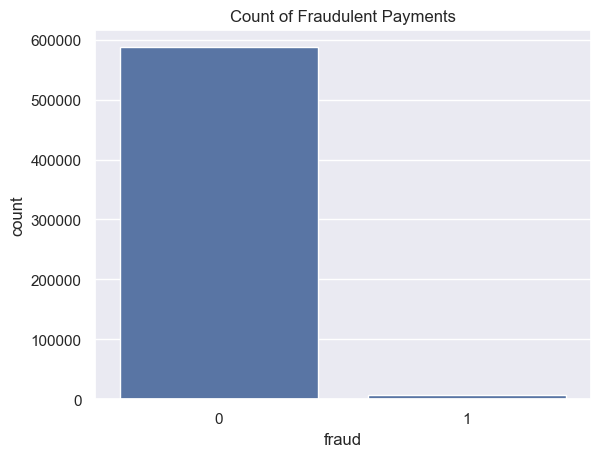

Number of normal examples:  587443
Number of fradulent examples:  7200


In [4]:
# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

We can see the mean amount and fraud percent by category below. Looks like leisure and the travel is the most selected categories for fraudsters. Fraudsters chose the categories which people spend more on average. Let's confirm this hypothesis by checking the fraud and non-fraud amount transacted.

In [108]:
print("Mean feature values per category",data.groupby('category')[['amount','fraud']].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


Our hypothesis for fraudsters choosing the categories which people spend more is only partly correct, but as we can see in the table below we can say confidently say that a fraudulent transaction will be much more (about four times or more) than average for that category.

In [9]:
# Create two dataframes with fraud and non-fraud data
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


Average amount spend it categories are similar; between 0-500 discarding the outliers, except for the travel category which goes very high.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


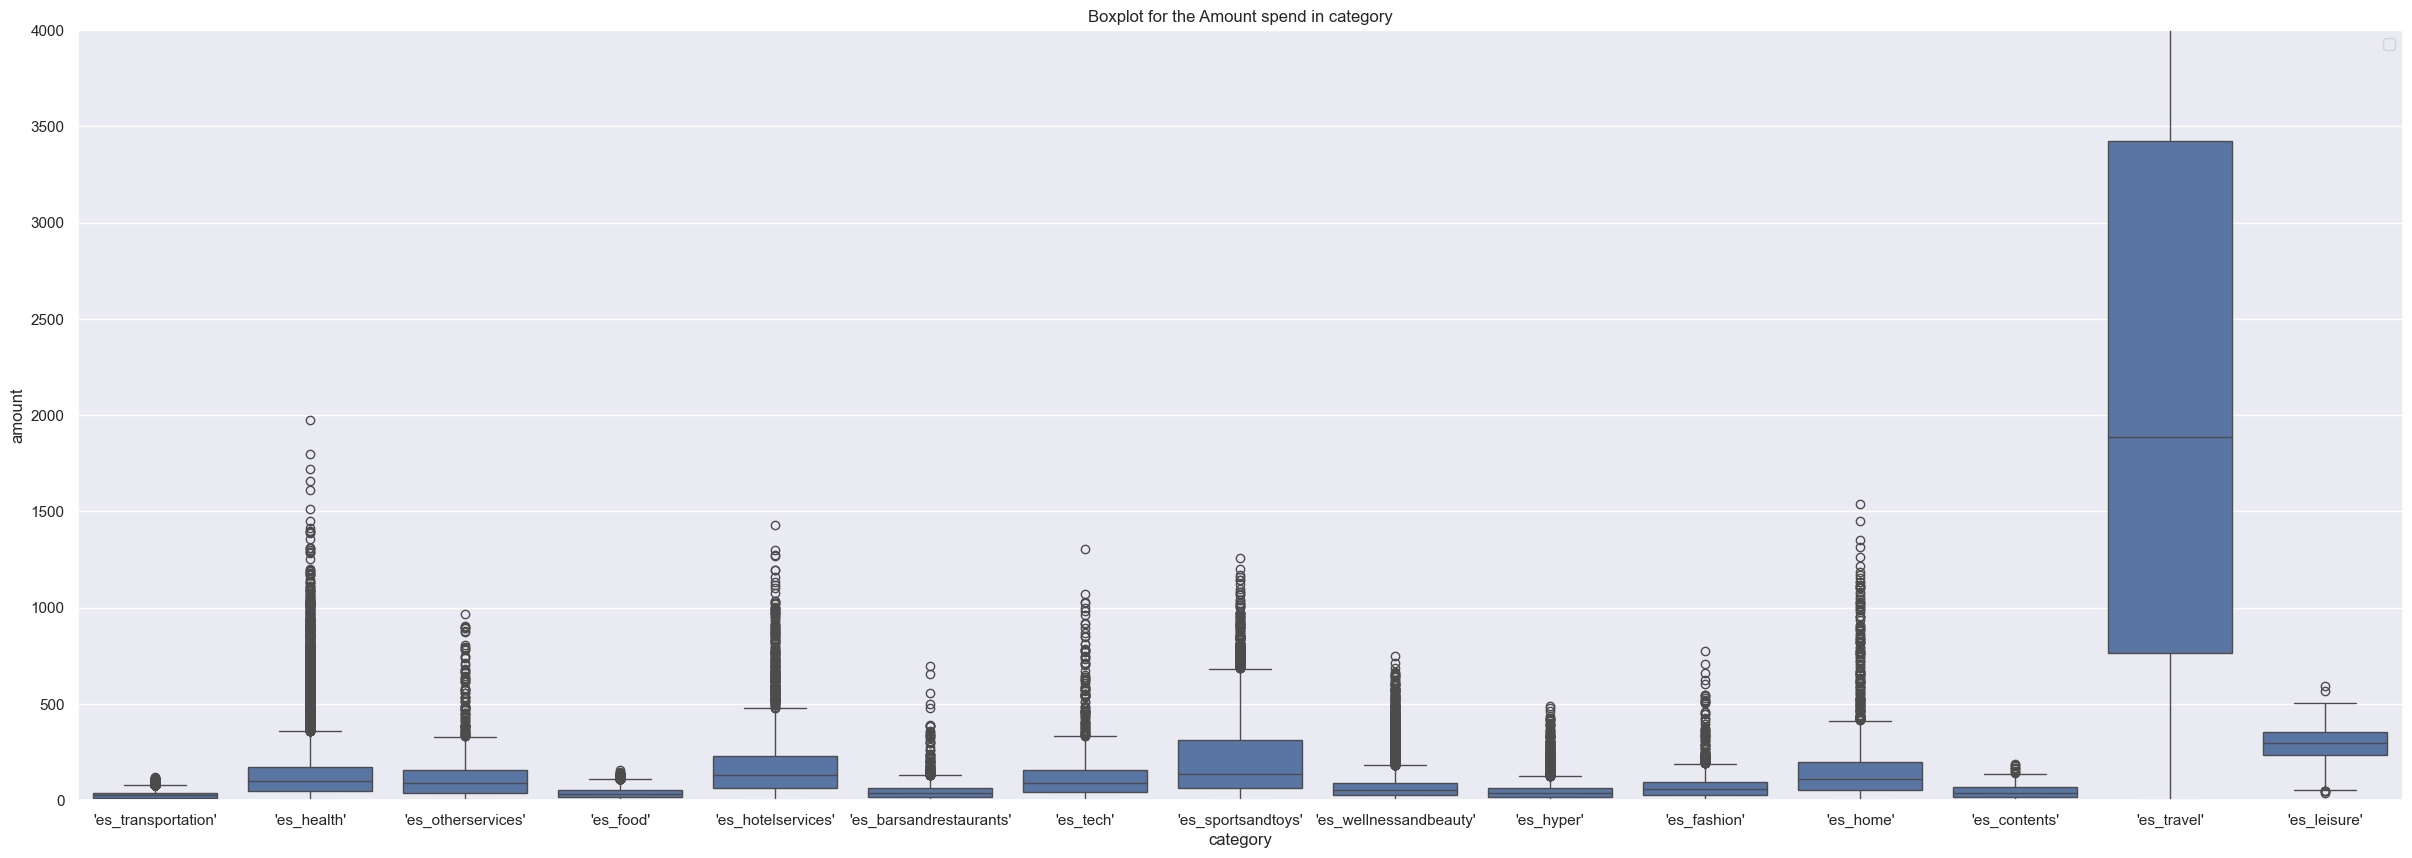

In [10]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

Again we can see in the histogram below the fradulent transactions are less in count but more in amount.

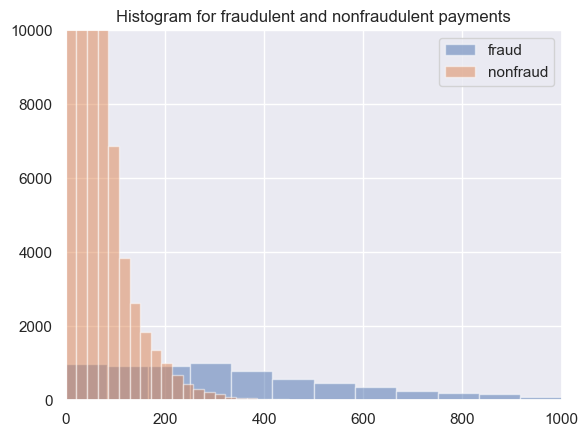

In [11]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

Looks like fraud occurs more in ages equal and below 18(0th category). Can it be because of fraudsters thinking it would be less consequences if they show their age younger, or maybe they really are young.

In [12]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


## Data Preprocessing

In this part we will preprocess the data and prepare for the training.

There are only one unique zipCode values so we will drop them.

In [13]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


Checking the data after dropping.

In [14]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

Here we will transform categorical features into numerical values. It is usually better to turn these type of categorical values into dummies because they have no relation in size(i.e. customer1 is not greater than customer2) but since they are too many (over 500k customers and merchants) the features will grow 10^5 in size and it will take forever to train. I've put the code below for turning categorical features into dummies if you want to give it a try.
> data_reduced.loc[:,['customer','merchant','category']].astype('category')
> data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) # dummies
> print(data_dum.info())

In [15]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


Let's define our independent variable (X) and dependant/target variable y

In [16]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [17]:
y[y==1].count()

7200

## Oversampling with SMOTE

Using SMOTE(Synthetic Minority Oversampling Technique) [2] for balancing the dataset. Resulted counts show that now we have exact number of class instances (1 and 0).

In [18]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res.value_counts())

fraud
0        587443
1        587443
Name: count, dtype: int64


I will do a train test split for measuring the performance. I haven't done cross validation since we have a lot of instances and i don't want to wait that much for training but it should be better to cross validate most of the times.

In [37]:
# I won't do cross validation since we have a lot of instances
X_train, X_test, Y_train, Y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

I will define a function for plotting the ROC_AUC curve. It is a good visual way to see the classification performance.

In [38]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

As i talked about it before fraud datasets will be imbalanced and most of the instances will be non-fraudulent. Imagine that we have the dataset here and we are always predicting non-fraudulent. Our accuracy would be almost 99 % for this dataset and mostly for others as well since fraud percentage is very low. Our accuracy is very high but we are not detecting any frauds so it is a useless classifier. So the base accuracy score should be better at least than predicting always non-fraudulent for performing a detection.

In [39]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ",
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


In [40]:
X_train.head()

,step,customer,age,gender,merchant,category,amount
903303,150,1005,3,1,35,4,318.801009
721176,63,496,2,1,49,10,607.125045
680561,82,2421,2,1,21,9,326.437076
1154749,18,598,4,1,40,13,2086.201087
752766,55,2809,1,1,42,5,1141.199516


## Giza

In [23]:
!giza users login

[WARN][2024-02-26 18:35:12.271] Current version of Giza CLI: 0.11.0
[WARN][2024-02-26 18:35:12.277] A new version (0.12.1) is available. Please upgrade 🔔
Enter your username 😎: ^C
Aborted.


In [ ]:
!giza users create-api-key

[WARN][2024-02-25 10:47:59.971] Current version of Giza CLI: 0.11.0
[WARN][2024-02-25 10:47:59.974] A new version (0.12.1) is available. Please upgrade 🔔
[giza][2024-02-25 10:47:59.977] Creating API Key ✅ 
[giza][2024-02-25 10:48:00.437] API Key written to: /root/.giza/.api_key.json
[giza][2024-02-25 10:48:00.438] Successfully created API Key. It will be used for future requests ✅ 


In [ ]:
!giza workspaces get

[WARN][2024-02-25 10:48:41.833] Current version of Giza CLI: 0.11.0
[WARN][2024-02-25 10:48:41.835] A new version (0.12.1) is available. Please upgrade 🔔
[giza][2024-02-25 10:48:41.837] Creating Workspace ✅ 
[WARN][2024-02-25 10:48:41.838] This process can take up to 10 minutes ⏳
[giza][2024-02-25 10:53:29.275] Worksace creation is successful ✅
[giza][2024-02-25 10:53:29.276] ✅ Workspace URL: https://actions-server-bilgin-kocak-dblzzhtf5q-ew.a.run.app ✅


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
import numpy as np
import logging
from scipy.ndimage import zoom
from giza_actions.action import action
from giza_actions.task import task
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
X_train.head()

,step,customer,age,gender,merchant,category,amount
903303,150,1005,3,1,35,4,318.801009
721176,63,496,2,1,49,10,607.125045
680561,82,2421,2,1,21,9,326.437076
1154749,18,598,4,1,40,13,2086.201087
752766,55,2809,1,1,42,5,1141.199516


In [87]:


input_size = 7  
hidden_size1 = 64
hidden_size2 = 32 
num_classes = 2
num_epochs = 10
batch_size = 256
learning_rate = 0.001

# Define the neural network architecture
class FraudClassifier(nn.Module):
    def __init__(self, input_features):
        super(FraudClassifier, self).__init__()
        self.layer1 = nn.Linear(input_features, 64)  # Input to first hidden layer
        self.layer2 = nn.Linear(64, 32)              # First to second hidden layer
        self.output = nn.Linear(32, 1)               # Second hidden layer to output
        
        self.relu = nn.ReLU()                        # ReLU activation function
        self.sigmoid = nn.Sigmoid()                  # Sigmoid activation function
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x


In [88]:

@task(name=f'Prepare Datasets')
def prepare_datasets():
    print("Prepare dataset...")
    x_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(Y_train.values, dtype=torch.float32)
    x_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(Y_test.values, dtype=torch.float32)
    print("✅ Datasets prepared successfully")
    return x_train, y_train, x_test, y_test


/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/tasks.py:339: UserWarning: A task named 'Prepare Datasets' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/task.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


In [89]:
@task(name=f'Create Loaders')
def create_data_loaders(x_train, y_train, x_test, y_test):
    print("Create loaders...")
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    print("✅ Loaders created successfully")
    return train_loader, test_loader

/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/tasks.py:339: UserWarning: A task named 'Create Loaders' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/task.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


In [90]:
@task(name=f'Train model')
def train_model(train_loader):
    print("Train model...")
    model = FraudClassifier(input_size).to(device)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    print("✅ Model trained successfully")
    return model

/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/tasks.py:339: UserWarning: A task named 'Train model' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/task.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


In [91]:
@task(name=f'Test model')
def test_model(model, test_loader):
    print("Test model...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Inference without calculating gradients
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}')
    print("✅ Model tested successfully")
    return accuracy

/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/tasks.py:339: UserWarning: A task named 'Test model' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/task.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(


In [46]:
@action(name=f'Execution', log_prints=True )
def execution():
    x_train, y_train, x_test, y_test = prepare_datasets()
    train_loader, test_loader = create_data_loaders(
        x_train, y_train, x_test, y_test)
    model = train_model(train_loader)
    test_model(model, test_loader)

execution()

/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/flows.py:337: UserWarning: A flow named 'Execution' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/action.py:1' conflicts with another flow. Consider specifying a unique `name` parameter in the flow definition:

 `@flow(name='my_unique_name', ...)`
  warnings.warn(


18:59:21.435 | INFO    | prefect.engine - Created flow run 'knowing-malamute' for flow 'Execution'

18:59:21.439 | INFO    | Flow run 'knowing-malamute' - View at https://actions-server-bilgin-kocak-dblzzhtf5q-ew.a.run.app/flow-runs/flow-run/a788a830-f89b-4a52-b442-934a01980dda

18:59:21.746 | INFO    | Flow run 'knowing-malamute' - Created task run 'Prepare Datasets-0' for task 'Prepare Datasets'

18:59:21.751 | INFO    | Flow run 'knowing-malamute' - Executing 'Prepare Datasets-0' immediately...

18:59:22.013 | INFO    | Task run 'Prepare Datasets-0' - Prepare dataset...

18:59:22.141 | INFO    | Task run 'Prepare Datasets-0' - ✅ Datasets prepared successfully

18:59:22.261 | INFO    | Task run 'Prepare Datasets-0' - Finished in state Completed()

18:59:22.382 | INFO    | Flow run 'knowing-malamute' - Created task run 'Create Loaders-0' for task 'Create Loaders'

18:59:22.385 | INFO    | Flow run 'knowing-malamute' - Executing 'Create Loaders-0' immediately...

18:59:22.666 | INFO    | Task run 'Create Loaders-0' - Create loaders...

18:59:22.675 | INFO    | Task run 'Create Loaders-0' - ✅ Loaders created successfully

18:59:22.801 | INFO    | Task run 'Create Loaders-0' - Finished in state Completed()

18:59:22.918 | INFO    | Flow run 'knowing-malamute' - Created task run 'Train model-0' for task 'Train model'

18:59:22.922 | INFO    | Flow run 'knowing-malamute' - Executing 'Train model-0' immediately...

18:59:23.145 | INFO    | Task run 'Train model-0' - Train model...

18:59:25.708 | INFO    | Task run 'Train model-0' - 0D or 1D target tensor expected, multi-target not supported

18:59:25.843 | INFO    | Task run 'Train model-0' - Finished in state Completed()

18:59:25.957 | INFO    | Flow run 'knowing-malamute' - Created task run 'Test model-0' for task 'Test model'

18:59:25.959 | INFO    | Flow run 'knowing-malamute' - Executing 'Test model-0' immediately...

18:59:26.170 | INFO    | Task run 'Test model-0' - Test model...

18:59:26.175 | INFO    | Task run 'Test model-0' - 'NoneType' object has no attribute 'eval'

18:59:26.302 | INFO    | Task run 'Test model-0' - Finished in state Completed()

18:59:26.430 | INFO    | Flow run 'knowing-malamute' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `tuple`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `tuple`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`'))]

In [92]:
import torch.onnx

@task(name=f'Convert To ONNX')
def convert_to_onnx(model, onnx_file_path):
    dummy_input = torch.randn(1, input_size).to(device)
    torch.onnx.export(model, dummy_input, onnx_file_path,
                      export_params=True, opset_version=10, do_constant_folding=True)

    print(f"Model has been converted to ONNX and saved as {onnx_file_path}")


@action(name="Action: Convert To ONNX", log_prints=True)
def execution():
    x_train, y_train, x_test, y_test = prepare_datasets()
    train_loader, test_loader = create_data_loaders(
        x_train, y_train, x_test, y_test)
    model = train_model(train_loader)
    test_model(model, test_loader)

    # Convert to ONNX
    onnx_file_path = "./verifiable_fraud.onnx"
    convert_to_onnx(model, onnx_file_path)


execution()

/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/tasks.py:339: UserWarning: A task named 'Convert To ONNX' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/task.py:3' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(
/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/prefect/flows.py:337: UserWarning: A flow named 'Action: Convert To ONNX' and defined at '/Users/bilginkocak/opt/anaconda3/envs/giza/lib/python3.11/site-packages/giza_actions/action.py:12' conflicts with another flow. Consider specifying a unique `name` parameter in the flow definition:

 `@flow(name='my_unique_name', ...)`
  warnings.warn(


19:37:27.993 | INFO    | prefect.engine - Created flow run 'dynamic-rook' for flow 'Action: Convert To ONNX'

19:37:27.996 | INFO    | Flow run 'dynamic-rook' - View at https://actions-server-bilgin-kocak-dblzzhtf5q-ew.a.run.app/flow-runs/flow-run/5d23e865-c67b-4867-95ee-0f9e15bda1bc

19:37:28.311 | INFO    | Flow run 'dynamic-rook' - Created task run 'Prepare Datasets-0' for task 'Prepare Datasets'

19:37:28.316 | INFO    | Flow run 'dynamic-rook' - Executing 'Prepare Datasets-0' immediately...

19:37:28.589 | INFO    | Task run 'Prepare Datasets-0' - Prepare dataset...

19:37:28.662 | INFO    | Task run 'Prepare Datasets-0' - ✅ Datasets prepared successfully

19:37:28.779 | INFO    | Task run 'Prepare Datasets-0' - Finished in state Completed()

19:37:28.903 | INFO    | Flow run 'dynamic-rook' - Created task run 'Create Loaders-0' for task 'Create Loaders'

19:37:28.906 | INFO    | Flow run 'dynamic-rook' - Executing 'Create Loaders-0' immediately...

19:37:29.126 | INFO    | Task run 'Create Loaders-0' - Create loaders...

19:37:29.128 | INFO    | Task run 'Create Loaders-0' - ✅ Loaders created successfully

19:37:29.279 | INFO    | Task run 'Create Loaders-0' - Finished in state Completed()

19:37:29.386 | INFO    | Flow run 'dynamic-rook' - Created task run 'Train model-0' for task 'Train model'

19:37:29.387 | INFO    | Flow run 'dynamic-rook' - Executing 'Train model-0' immediately...

19:37:29.604 | INFO    | Task run 'Train model-0' - Train model...

19:37:37.071 | INFO    | Task run 'Train model-0' - Epoch 1/10, Loss: 0.2571542831737788

19:37:44.771 | INFO    | Task run 'Train model-0' - Epoch 2/10, Loss: 0.20945923428065377

19:37:52.448 | INFO    | Task run 'Train model-0' - Epoch 3/10, Loss: 0.1885135024345407

19:38:00.034 | INFO    | Task run 'Train model-0' - Epoch 4/10, Loss: 0.17060851111400546

19:38:07.440 | INFO    | Task run 'Train model-0' - Epoch 5/10, Loss: 0.14693891301570264

19:38:15.363 | INFO    | Task run 'Train model-0' - Epoch 6/10, Loss: 0.1349225232230979

19:38:22.991 | INFO    | Task run 'Train model-0' - Epoch 7/10, Loss: 0.12876735927019392

19:38:30.777 | INFO    | Task run 'Train model-0' - Epoch 8/10, Loss: 0.12234787259759874

19:38:38.471 | INFO    | Task run 'Train model-0' - Epoch 9/10, Loss: 0.11698825470581442

19:38:46.560 | INFO    | Task run 'Train model-0' - Epoch 10/10, Loss: 0.11401156731671053

19:38:46.562 | INFO    | Task run 'Train model-0' - ✅ Model trained successfully

19:38:46.790 | INFO    | Task run 'Train model-0' - Finished in state Completed()

19:38:46.898 | INFO    | Flow run 'dynamic-rook' - Created task run 'Test model-0' for task 'Test model'

19:38:46.901 | INFO    | Flow run 'dynamic-rook' - Executing 'Test model-0' immediately...

19:38:47.132 | INFO    | Task run 'Test model-0' - Test model...

19:38:49.319 | INFO    | Task run 'Test model-0' - Accuracy on the test set: 127.98

19:38:49.321 | INFO    | Task run 'Test model-0' - ✅ Model tested successfully

19:38:49.457 | INFO    | Task run 'Test model-0' - Finished in state Completed()

19:38:49.579 | INFO    | Flow run 'dynamic-rook' - Created task run 'Convert To ONNX-0' for task 'Convert To ONNX'

19:38:49.583 | INFO    | Flow run 'dynamic-rook' - Executing 'Convert To ONNX-0' immediately...

19:38:50.058 | INFO    | Task run 'Convert To ONNX-0' - Model has been converted to ONNX and saved as ./verifiable_fraud.onnx

19:38:50.178 | INFO    | Task run 'Convert To ONNX-0' - Finished in state Completed()

19:38:50.301 | INFO    | Flow run 'dynamic-rook' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `tuple`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `tuple`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `FraudClassifier`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `float`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `NoneType`'))]

In [106]:
from giza_actions.model import GizaModel
import torch.nn.functional as F

def prepare_datasets():
    print("Prepare dataset...")
    x_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(Y_train.values, dtype=torch.float32)
    x_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(Y_test.values, dtype=torch.float32)
    print("✅ Datasets prepared successfully")
    return x_train, y_train, x_test, y_test


# @task(name=f'Prediction with ONNX')
def prediction(input):
    model = GizaModel(model_path="./verifiable_fraud.onnx")

    numpy_input = input.numpy().reshape(1, -1)
    print(f"Input: {numpy_input}")

    result = model.predict(
        input_feed={"onnx::Gemm_0": numpy_input}, verifiable=False
    )
    print(f"Result of Model: {result}")
    if result[0] > 0.5:
        result = 1
    else:
        result = 0
    return result


# @action(name=f'Execution: Prediction with ONNX', log_prints=True )
def execution():
    x_train, y_train, x_test, y_test = prepare_datasets()
    outputs = prediction(x_test[0])
    print(f"Output of Model: {outputs}")
    print("Correct Output: ", y_test[0].item())
    print("✅ Prediction with ONNX completed successfully")

    return outputs


execution()

Prepare dataset...
✅ Datasets prepared successfully
Input: [[ 54.      693.        2.        1.       40.        9.      408.15845]]
Result of Model: [[0.999619]]
Output of Model: 1
Correct Output:  1.0
✅ Prediction with ONNX completed successfully


1

In [107]:
MODEL_ID = 392  # Update with your model ID
VERSION_ID = 1  # Update with your version ID


@task(name=f'Prediction with Cairo')
def prediction(input, model_id, version_id):

    numpy_input = input.numpy().reshape(1, -1)
    model = GizaModel(id=model_id, version=version_id)

    (result, request_id) = model.predict(
        input_feed={"input": numpy_input}, verifiable=True, output_dtype="Tensor<FP16x16>"
    )

    # Convert result to a PyTorch tensor
    result_tensor = torch.tensor(result)

    return result_tensor, request_id


@action(name=f'Execution: Prediction with Cairo', log_prints=True)
def execution():
    x_train, y_train, x_test, y_test = prepare_datasets()

    (result, request_id) = prediction(x_test[0], MODEL_ID, VERSION_ID)
    print("Result: ", result)
    print("Request id: ", request_id)

    return result, request_id


execution()

20:28:04.410 | INFO    | prefect.engine - Created flow run 'voracious-dachshund' for flow 'Execution: Prediction with Cairo'

20:28:04.419 | INFO    | Flow run 'voracious-dachshund' - View at https://actions-server-bilgin-kocak-dblzzhtf5q-ew.a.run.app/flow-runs/flow-run/d36bdb9b-8869-4caf-b909-689f3d0704a9

20:28:04.632 | INFO    | Flow run 'voracious-dachshund' - Prepare dataset...

20:28:04.701 | INFO    | Flow run 'voracious-dachshund' - ✅ Datasets prepared successfully

20:28:04.811 | INFO    | Flow run 'voracious-dachshund' - Created task run 'Prediction with Cairo-0' for task 'Prediction with Cairo'

20:28:04.813 | INFO    | Flow run 'voracious-dachshund' - Executing 'Prediction with Cairo-0' immediately...

🚀 Starting deserialization process...
✅ Deserialization completed! 🎉


20:28:11.554 | INFO    | Task run 'Prediction with Cairo-0' - Finished in state Completed()

20:28:11.560 | INFO    | Flow run 'voracious-dachshund' - Result:  tensor([[0.9996]], dtype=torch.float64)

20:28:11.563 | INFO    | Flow run 'voracious-dachshund' - Request id:  "a593b274de074d248fdd341fed1b0c95"

20:28:11.683 | INFO    | Flow run 'voracious-dachshund' - Finished in state Completed()

(tensor([[0.9996]], dtype=torch.float64), '"a593b274de074d248fdd341fed1b0c95"')

In [111]:
!giza deployments download-proof --model-id 392 --version-id 1  --deployment-id 70 --proof-id a593b274de074d248fdd341fed1b0c95 --output-path proof.json

[WARN][2024-02-26 20:55:40.630] Current version of Giza CLI: 0.11.0
[WARN][2024-02-26 20:55:40.634] A new version (0.12.1) is available. Please upgrade 🔔
[giza][2024-02-26 20:55:40.639] Getting proof from deployment 70 ✅ 
[ERROR][2024-02-26 20:55:41.251] ⛔️Could not get deployment 70
[ERROR][2024-02-26 20:55:41.252] ⛔️Detail -> ⛔️
[ERROR][2024-02-26 20:55:41.253] ⛔️Status code -> 500⛔️
[ERROR][2024-02-26 20:55:41.254] ⛔️Error message -> Internal Server Error⛔️


## Conclusion

In the rapidly evolving digital landscape, the specter of financial fraud looms large, presenting anongoing challenge for sectors ranging from e-commerce to banking. The advent of sophisticated fraudulent schemes has necessitated the development of equally advanced detection mechanisms. This kernel explores the integration of verifiable machine learning (ML) using Giza Actions SDK [[3]](#3) in crafting a fraud detection model that not only identifies fraudulent transactions with high accuracy but also ensures the integrity and verifiability of the detection process itself. Leveraging the Banksim dataset, a synthetic representation of typical banking transactions, this study underscores the potential of combining traditional rule-based systems with the dynamic, learning-oriented approach of ML.

## Resources

[[1]](#-1). Lavion, Didier; et al. ["PwC's Global Economic Crime and Fraud Survey 2018"](https://www.pwc.com/gx/en/forensics/global-economic-crime-and-fraud-survey-2018.pdf) (PDF). PwC.com. Retrieved 28 August 2018.

[[2]](#2). [SMOTE: Synthetic Minority Over-sampling Technique](https://jair.org/index.php/jair/article/view/10302)

[[3]](#3). [Giza Actions SDK](https://actions.gizatech.xyz/welcome/giza-actions-sdk)